# Computing the Jacobian for heterogeneous-agent blocks

This notebook accompanies work in progress by Auclert, Bardóczy, Rognlie, Straub (2019): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Please see the [Github repository](https://github.com/shade-econ/sequence-jacobian) for more information and code.

## 0 Import packages

In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

import hank
import het_block as het
import jacobian as jac
import utils


## 1 Getting the sequence-space Jacobian through brute force
In the `hank.py` module, the `hank.household_td` function evaluates the household sector's individual and aggregate outcomes for assets, consumption, and labor in response to changing any sequence of aggregate inputs to the household problem.

Suppose we are interested in household behavior in response to changing wages `w` and real interest rates `r`. First, we compute a calibrated steady state.

In [2]:
ss = hank.hank_ss()

We can construct the sequence-space Jacobian, relating aggregate outcomes for the paths of assets `A`, consumption `C`, labor `N`, and effective skill-augmented labor `NS` to inputs for the paths of `w` and `r` through brute force: evaluate `household_td` on a small shock to each of these at every single date up to our truncation horizon `T`.

We get the $t=200$ columns of Jacobians with respect to `w` by evaluating on a small shock to `w` at time 200, the $t=201$ column by evaluating on a small shock to `w` at time 201, and so on. Ultimately, if $T=300$, we need to run `household_td` 600 times, 300 each for `w` and `r`; and each of these runs involves a backward and a forward iteration.

In [3]:
%%time
T = 300
J_bruteforce = {}
inputs = ('w', 'r')
outcomes = ('A', 'C', 'N', 'NS')
h = 1E-4

# make J as a nested dict where J[o][i] is initially-empty T*T Jacobian
J_bruteforce = {o: {i: np.empty((T, T)) for i in inputs} for o in outcomes}

# run td once without any shocks to get paths to subtract against (better than subtracting by ss since ss not exact)
td_noshock = hank.household_td(hank.backward_iterate_labor, ss, w=np.full(T, ss['w']))

for i in inputs:
    # simulate with respect to a shock at each date up to T
    for t in range(T):
        td_out = hank.household_td(hank.backward_iterate_labor, ss, **{i: ss[i]+h*(np.arange(T) == t)})
        
        # store results as column t of J[o][i] for each outcome o
        for o in outcomes:
            J_bruteforce[o][i][:, t] = (td_out[o] - td_noshock[o])/h

AttributeError: module 'hank' has no attribute 'household_td'

Once we have the Jacobians, we have enough information to calculate the response, to first order, to any sequence of changes in `w` or `r`. This is essentially instantaneous, since it's just matrix-vector multiplication. For instance, we can calculate the consumption response to a 50-basis-point decline in real interest rates with persistence 0.8, and validate that it is essentially the same as what we get from the `household_td` routine (since nonlinearities here are quite slight).

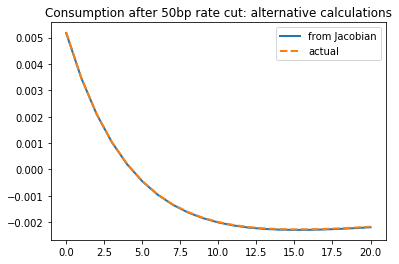

In [8]:
rshock = -0.005*0.8**np.arange(T)
C_from_J = J_bruteforce['C']['r'] @ rshock
C_actual = hank.household_td(hank.backward_iterate_labor, ss, r=ss['r']+rshock)['C'] - ss['C']
plt.plot(C_from_J[:21], label='from Jacobian', linewidth=2)
plt.plot(C_actual[:21], label='actual', linestyle='--', linewidth=2)
plt.legend()
plt.title('Consumption after 50bp rate cut: alternative calculations')
plt.show()

As we've emphasized elsewhere, the Jacobian is especially useful if we want to quickly calculate responses to "news" shocks, e.g. the following 0.1% increase in wages at date 10, for which we can directly observe the response as just the 10th column of the already-calculated Jacobian, scaled by 0.1%.

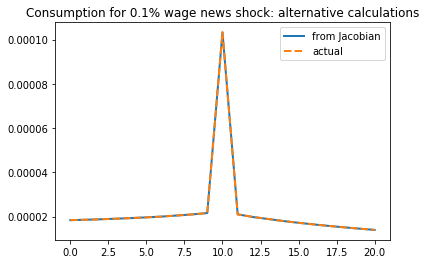

In [9]:
wshock = 0.001*(np.arange(T) == 10)
C_from_J = 0.001*J_bruteforce['C']['w'][:,10]
C_actual = hank.household_td(hank.backward_iterate_labor, ss, w=ss['w'] + wshock)['C'] - ss['C']
plt.plot(C_from_J[:21], label='from Jacobian', linewidth=2)
plt.plot(C_actual[:21], label='actual', linestyle='--', linewidth=2)
plt.legend()
plt.title('Consumption for 0.1% wage news shock: alternative calculations')
plt.show()

The brute-force approach can be a useful default way to calculate the Jacobian for anyone who wants to use the Jacobian for solution or estimation as described in our paper. The problem is that it is **slow**. Above, it takes about 60 seconds for the HANK model with endogenous labor to for inputs `w` and `r`, not terrible since it only needs to be calculated once. Calculating with respect to other inputs would increase the time proportionately.

It becomes more impractical, however, when the heterogeneous-agent model is larger, slower, or otherwise more complicated, because then each run of backward and forward iteration can be much more costly. (We benefit here since our underlying code for the HANK model is quite efficient, but this is not always the case.) These more difficult applications are precisely the set of cases where our Jacobian-based methods -- which allow the user to forget about the underlying heterogeneous-agent model once the Jacobian is calculated -- are most useful, and it is imperative to have a more efficient method to address them.

## 2 First speed-up: exploiting time symmetry in the backward iteration
Let's take a step back and think about some theory (please see the slides for a complementary presentation of some of the details). Our usual objective is to find the time path of aggregate outcomes $Y_t\in \mathbb{R}$, where

$$Y_t \equiv y_t'D_t$$

with $y_t\in \mathbb{R}^n$ are the individual outcomes at each point in the discretized state space, and $D_t \in \mathbb{R}^n$ is the distribution's mass at each point in the discretized state space.

The individual state-dependent outcomes $y_t$ are things like asset demand, consumption, labor, and so on, that are determined by the optimizing, forward-looking choices of agents. They can be obtained through backward iteration -- history dependence comes only through the $D_t$ term.

To first order around the steady state, we have the following key decomposition:

$$dY_t = \underbrace{dy_t'D_{ss}}_{\text{current}} + \underbrace{y_{ss}'dD_t}_{\text{history}} \tag{1}$$

The first term takes the changes today's individual $y_t$ at each state, and aggregates them holding the distribution of agents $D_{ss}$ constant at the steady state. Since it comes from changes to the behavior of agents today, we call this term the **current** effect. The second term takes changes in the distribution across agents at the start of the period, and finds the aggregate effect holding the individual outcomes $y_{ss}$ constant at the steady state. Since any change in the distribution at the start of the period must have originated in different policies in the past (assuming that we started at the steady state), we call this term the **history** effect.

### 2.1 The current effect is easy!
Suppose that there is some shock at date $s$ — for instance, a 50-basis-point cut in $r$. Then the change $dy_t$ in individual outcomes depends only on the time $s-t$ until the shock: $dy_5$ if the rate cut is at $s=10$ is the same as $dy_{10}$ if the same rate cut is at $s=15$. Also, $dy_t=0$ if $s<t$. These are direct implications of the fact that we can obtain $y_t$ from a time-invariant backward iteration.

We can thus define
$$\mathcal{Y}_{s-t}^{o,i} \equiv dy_t'D_{ss} \tag{2}$$
to be the resulting change $dY_t^o$ in outcome $o$ in response to a unit shock to input $i$.

We can get all these $\mathcal{Y}_{s-t}^{o,i}$ for a given $i$ by doing a *single* backward iteration given a unit shock in $i$ in period $T-1$. Let's do this for inputs $w$ and $r$, like above.

In [10]:
%%time
curlyY = {o: {i: np.empty(T) for i in inputs} for o in outcomes}
Dss = ss['D'].ravel()

for i in inputs:
    # simulate given a SINGLE shock at the final date, T-1
    td_out = hank.household_td(hank.backward_iterate_labor, ss, **{i: ss[i]+h*(np.arange(T) == (T-1))})
    
    # aggregate effects on individual outcome assuming steady-state distribution
    for o in outcomes:
        # household_td reports individual outcomes with lowercase variable names
        ol = o.lower()
        
        # dy is a T*n array with, for each T, change in individual outcome at each state
        # internally the state space is stored with two dimensions (exogenous skill and endogenous asset)
        # so we use a reshape to collapse to a single dimension
        dy = ((td_out[ol] - td_noshock[ol])/h).reshape((T, -1))
        
        # now reverse direction of ts and matrix multiply by length-n ss distribution
        # to get length-T curlyY
        curlyY[o][i] = dy[::-1, :] @ Dss

CPU times: user 458 ms, sys: 22 ms, total: 480 ms
Wall time: 317 ms


Since this is requires just a single application of `household_td` rather than $T=300$ of them, it is far faster than before.

Let's verify that the `curlyY` we've calculated gives the correct *current* effect in response to shocks. Consider, like before, a 0.1% shock to wages at date 10. The current effect on consumption in period $t\leq 10$ is then just $0.1\%\times\mathcal{Y}_{10-t}^{C, w}$; it is zero for any $t>10$.

Alternatively, we can calculate the current effect by running `backward_iterate_labor` and aggregating individual consumption outcomes using the steady-state distribution.

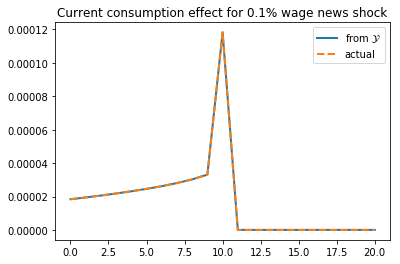

In [11]:
wshock = 0.001*(np.arange(T) == 10)
C_current_from_curlyY = np.zeros(T)
C_current_from_curlyY[:11] = 0.001*curlyY['C']['w'][10::-1]

c_actual = (hank.household_td(hank.backward_iterate_labor, ss, w=ss['w'] + wshock)['c'] - ss['c']).reshape((T, -1))
C_current_actual = c_actual @ Dss

plt.plot(C_current_from_curlyY[:21], label=r'from $\mathcal{Y}$', linewidth=2)
plt.plot(C_current_actual[:21], label='actual', linestyle='--', linewidth=2)
plt.legend()
plt.title('Current consumption effect for 0.1% wage news shock')
plt.show()

We see that $\mathcal{Y}$ correctly gave the current effect of the shock. It's also interesting to study the current effect in contrast to our earlier figure giving the full effect of the wage news shock. Here, anticipatory spending prior to $t=10$ slopes up more strongly (because we are ignoring the fact that anticipatory spending in earlier periods shifts down the distribution of assets), and then the $t=10$ response is also larger (for the same reason). There is no effect afterward, since we aren't including history effects.

To sum up, we've shown that we can rapidly calculate $\mathcal{Y}$, defined in (2), and that we can use this to calculate the "current effect" portion of the decomposition in (1) for a shock at some date $s$. This gets us part of the way to the Jacobian -- what remains is the "history effect".

### 2.2 The history effect is harder, but time symmetry in the backward iteration helps somewhat
Let's repeat equation (1):

$$dY_t = \underbrace{dy_t'D_{ss}}_{\text{current}} + \underbrace{y_{ss}'dD_t}_{\text{history}}$$

We've already characterized the "current" effect. What about the "history" effect?

The law of motion for $D_t$ is given by

$$D_{t+1} = \Lambda_{t}'D_{t}$$

where $\Lambda_{t}$ is the $n\times n$ Markov transition probability matrix between states in $t$ and $t+1$. To first order, we have the decomposition:

$$dD_{t+1} = d\Lambda_t'D_{ss} + \Lambda_{ss}'dD_{t} \tag{3}$$

This is a recursive equation in $dD_t$. Since the change in transition probabilities $d\Lambda_t$ results from changes in individual policies in response to shocks in $t$ and later, it can be obtained from backward iteration too, and there is a time symmetry exactly like in 2.1, where we can define

$$\mathcal{D}_{s-t}^{i} \equiv d\Lambda_t'D_{ss} \tag{4}$$

for a given shocked input $i$ in a way that depends only on $s-t$. Of course, $d\Lambda_t=0$ for all $s<t$.

How do we calculate the $\mathcal{D}$ in response to the same input shocks we've considered so far, $w$ and $r$? First, we obtain shocks to the asset policy $a$ of households at each horizon. These shocks determine the change $d\Lambda$ in the Markov matrix.

The discretized $\Lambda$ in our code has a particular structure: each gridpoint sends part of its mass to two neighboring gridpoints, which average out to be the policy $a$ (see e.g. [Young 2010](https://www.sciencedirect.com/science/article/pii/S0165188909001316)). We store the index of the left of these two gridpoints in an array `a_pol_i`, and the fraction going to the left gridpoint in an array `a_pol_pi` (the rest goes to the gridpoint to the right). An infinitesimal shock to the policy `a` will show up in a corresponding infinitesimal shock to `a_pol_pi`. We then use a special function, `het.forward_step_policy_shock`, to apply the $d\Lambda'$ corresponding to the change in `a_pol_pi` to the steady-state distribution, ending up with the $\mathcal{D}$s.

In [12]:
%%time
curlyD = {}

# precalculate steady-state a_pol_i, a_pol_pi
a_pol_i, a_pol_pi = utils.interpolate_coord(ss['a_grid'], ss['a'])

# precalculate steady-state difference between policy gridpoints where we send mass
a_pol_diff = ss['a_grid'][a_pol_i + 1] - ss['a_grid'][a_pol_i]

for i in inputs:
    # simulate given a SINGLE shock at the final date, T-1
    td_out = hank.household_td(hank.backward_iterate_labor, ss, **{i: ss[i]+h*(np.arange(T) == (T-1))})
    
    # effect on asset policy
    da = (td_out['a'] - td_noshock['a']) / h
    
    # effect on a_pol_pi, fraction going to left gridpoint of policy
    da_pol_pi = -da / a_pol_diff
    
    # apply da_pol_pi in each period to get curlyD, and reverse order
    curlyD[i] = np.empty_like(da)
    for t in range(T):
        curlyD[i][t, ...] = utils.forward_step_policy_shock(
                                 ss['D'], ss['Pi'].T, a_pol_i, da_pol_pi[T-1-t, ...])

CPU times: user 461 ms, sys: 21 ms, total: 482 ms
Wall time: 488 ms


Now let's verify that these $\mathcal{D}$ are correct, by seeing if we can use them to compute the correct history effect. Suppose yet again that we have a 0.1% shock to wages at date 10. We can then build up the sequence $dD_t$ by iterating on (3). We use the function `mathutils.forward_step` with the steady-state `a_pol_i` and `a_pol_pi` to apply $\Lambda_{ss}'$.

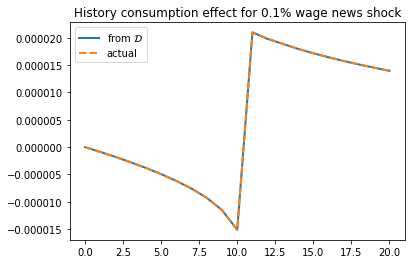

In [13]:
wshock = 0.001*(np.arange(T) == 10)

# first calculate history effect using our formula
C_history_from_curlyD = np.empty(T)

# initialize to no change in distribution
dD = np.zeros_like(ss['D'])
for t in range(T):
    # calculate history effect at date t
    C_history_from_curlyD[t] = np.vdot(ss['c'], dD)
    
    # multiply by Lambda_{ss}'
    dD = utils.forward_step(dD, ss['Pi'].T, a_pol_i, a_pol_pi)
    
    # add other term in (3) using curlyD
    if t <= 10:
        dD += 0.001*curlyD['w'][10-t, ...]

# alternative: compute actual history effect by multiplying actual D changes by steady-state c
D_actual = (hank.household_td(hank.backward_iterate_labor, ss, w=ss['w'] + wshock)['D'] - ss['D']).reshape((T, -1))
C_history_actual = D_actual @ ss['c'].ravel()

plt.plot(C_history_from_curlyD[:21], label=r'from $\mathcal{D}$', linewidth=2)
plt.plot(C_history_actual[:21], label='actual', linestyle='--', linewidth=2)
plt.legend()
plt.title('History consumption effect for 0.1% wage news shock')
plt.show()

Success! We can also plot the full actual response (which we calculated earlier, and we showed was just column 10 of the Jacobian for $C$ and $w$, scaled by 0.1%) against the combined current and history effects, to verify that our computational strategy works.

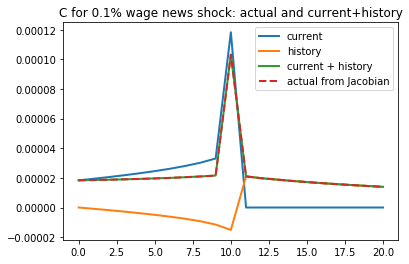

In [14]:
plt.plot(C_current_from_curlyY[:21], label=r'current', linewidth=2)
plt.plot(C_history_from_curlyD[:21], label=r'history', linewidth=2)
plt.plot(C_current_from_curlyY[:21] + C_history_from_curlyD[:21], label=r'current + history', linewidth=2)
plt.plot(0.001*J_bruteforce['C']['w'][:21, 10], label='actual from Jacobian', linestyle='--', linewidth=2)
plt.legend()
plt.title('C for 0.1% wage news shock: actual and current+history')
plt.show()

### 2.3 Summing up and calculating full Jacobians
To conclude, we have showed how to easily calculate a set of $\mathcal{Y}_u^{o,i}$ and $\mathcal{D}_u^{i}$, with a single backward iteration for each $i$. With these in hand, for any unit shock to $i$ at date $s$, we can use modified (1) and (3) to calculate the response of outcome $o$:

\begin{align}
dY_t^o &= \mathcal{Y}_{s-t}^{o,i} + (y_{ss}^o)'dD_t \tag{1'}\\
dD_{t+1} &= \mathcal{D}_{s-t}^i + \Lambda_{ss}'dD_t \tag{3'}
\end{align}

The problem comes with (3'). We still need to recursively calculate the full path of $dD_t$ *separately* for each shock to $i$ and date of the shock $s$. We can see this below, where we implement calculating `J_from_curlyYD`.

In [16]:
%%time
J_from_curlyYD = {o: {i: np.empty((T, T)) for i in inputs} for o in outcomes}

# loop over inputs to shock (w, r) and columns s
for i in inputs:
    for s in range(T):
        # initialize distribution to zero
        dD = np.zeros_like(ss['D'])
    
        for t in range(T):
            for o in outcomes:
                # calculate history effect at t for each output
                J_from_curlyYD[o][i][t, s] = np.vdot(dD, ss[o.lower()])
                
                # add current effect
                if t <= s:
                    J_from_curlyYD[o][i][t, s] += curlyY[o][i][s-t]
                
            # multiply by Lambda_{ss}'
            dD = utils.forward_step(dD, ss['Pi'].T, a_pol_i, a_pol_pi)
    
            # add other term in (3) using curlyD
            if t <= s:
                dD += curlyD[i][s-t, ...]    

CPU times: user 4.22 s, sys: 39.7 ms, total: 4.26 s
Wall time: 4.3 s


This is a massive improvement, by well over an order of magnitude (little changed by including the minor earlier computation time required to compute the $\mathcal{Y}$ and $\mathcal{D}$). We can verify graphically that the columns of these Jacobians are effectively identical to the ones we calculated using the brute force approach, for instance for the consumption response to wage shocks:

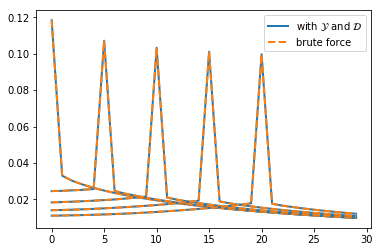

In [17]:
columns = (0, 5, 10, 15, 20)
l1, l2 = r'with $\mathcal{Y}$ and $\mathcal{D}$', 'brute force'
for col in columns:
    plt.plot(J_from_curlyYD['C']['w'][:30, col], label=l1, linewidth=2, color='C0')
    plt.plot(J_bruteforce['C']['w'][:30, col], label=l2, linestyle='--', linewidth=2, color='C1')
    l1, l2 = '_nolegend_', '_nolegend_' # suppress extra legends
plt.legend()
plt.show()

Or we can look through all pairs of outcomes and inputs and show the maximum difference between Jacobians (noting that the differences show up here because of second-order effects in numerical differentiation, with the brute-force approach suffering more from these effects).

In [18]:
for o in outcomes:
    diffs = [np.max(np.abs(J_from_curlyYD[o][i] - J_bruteforce[o][i])) for i in inputs]
    print(f'Outcome {o} max diff for inputs: ')
    print(',\t'.join([f'{i}: {d:.3e}' for i, d in zip(inputs, diffs)]) + '\n')

Outcome A max diff for inputs: 
w: 1.952e-05,	r: 9.659e-04

Outcome C max diff for inputs: 
w: 1.443e-05,	r: 1.367e-05

Outcome N max diff for inputs: 
w: 2.623e-05,	r: 1.032e-05

Outcome NS max diff for inputs: 
w: 1.433e-05,	r: 8.222e-06



The approach with $\mathcal{Y}$ and $\mathcal{D}$, however, still requires a full forward iteration implementing (3') recursively for each date and type of income shock. It therefore economizes on backward but not forward iteration.

This achieves large speedups in our case since our highly efficient forward iteration code means that backward iteration is the main bottleneck, but it could be less impressive in other applications. As we will see, it remains unnecessarily costly by more than an order of magnitude.

## 3 Second speed-up: exploiting symmetry in the forward iteration
As we just discussed, once we have obtained the full set of $\mathcal{Y}$s and $\mathcal{D}$s using the methods of section 2, the primary limitation is the need to do a full forward iteration with (3') for each input shock at each date.

To improve on this, consider expanding (1') and (3') for the first few $t$ (for any $s$), dropping the $o, i$ superscripts for simplicity:

\begin{align}
dY_0 &= \mathcal{Y}_s \\
dY_1 &= \mathcal{Y}_{s-1} + y_{ss}'\mathcal{D}_{s-1} \\
dY_2 &= \mathcal{Y}_{s-2} + y_{ss}'\mathcal{D}_{s-2} + y_{ss}'(\Lambda_{ss}')\mathcal{D}_{s-1} \\
dY_3 &= \mathcal{Y}_{s-3} + y_{ss}'\mathcal{D}_{s-3} + y_{ss}'(\Lambda_{ss}')\mathcal{D}_{s-2} + y_{ss}'(\Lambda_{ss}')^2\mathcal{D}_{s-1}
\end{align}

and so on.

Other than the $\mathcal{Y}$s, we see that all the terms have a particular form:

$$y_{ss}'(\Lambda_{ss}')^u \mathcal{D}_v \tag{5}$$

for some $u,v$. Our remaining computational challenge is that calculating $(\Lambda_{ss}')^u \mathcal{D}_v$ for all pairs $u,v$ requires many forward iterations, like we needed in the previous section.

It turns out that we can do much better by simply changing the *order of evaluation* of (5). Rather than computing $(\Lambda_{ss}')^u \mathcal{D}_v$ for all pairs $u,v$, we can first compute $y_{ss}'(\Lambda_{ss}')^u$ for all $u$, and only *then* take the product (5) for all $v$.

The advantage of this approach is that we can calculate $y_{ss}'$, $y_{ss}'(\Lambda_{ss}')$, $y_{ss}'(\Lambda_{ss}')^2$, etc. with a single recursion.

### 3.1 Prediction vectors
We define the $t$-**prediction vector** $\mathcal{P}_t^o\in \mathbb{R}^n$ for outcome $o$ to be

$$
\mathcal{P}_t^o \equiv (\Lambda_{ss})^t y_{ss}^o \tag{6}
$$

Prediction vectors answer the following question. Suppose that we shock the time-$u$ distribution $dD_u$ and hold everything else constant, and we want to know the effect of the persistence of this distributional shock on aggregate outcomes $dY_u^o, dY_{u+1}^o, \ldots$. 

This is given by the product of the $t$-prediction vector with $dD_u$:

$$
dY_{u+t}^o = (y_{ss}^o)'(\Lambda_{ss}')^t dD_u = (\mathcal{P}_t^o)'dD_u
$$

as can be immediately derived from (3).

Prediction vectors capture a time symmetry in the forward iteration, which is that the linear relationship between $dD_u$ and $dY_{u+t}^o$ depends *only on t*. $Y$ is an aggregate, which means that prediction vectors are merely length-$n$ vectors: applying one of them to the $n$-dimensional distribution should produce a single number.

We can thus (almost magically) *predict* the effect of $dD_u$ on $dY_{u+t}^o$ by taking a single length-$n$ dot product, without ever explicitly calculating the evolution of the distributions $dD_{u+1}, dD_{u+2},\ldots$ that lead there.

To calculate the prediction vectors, we must implement (6), which when calculated recursively requires us to multiply each $y_{ss}^o$ repeatedly by the steady-state Markov matrix $\Lambda_{ss}$. We already know how to multiply by $\Lambda_{ss}'$, which is just forward iteration on distributions. Multiplying by $\Lambda_{ss}$ is the transpose operation, which in our custom sparsity-exploiting code is just a matter of swapping some operations. This is done in the function `utils.forward_step_transpose`.

Let's calculate a full set of $\mathcal{P}_t^o$ for all our outcomes $o$ and $t$ up to $T$.

In [19]:
# run forward_step_transpose so that time doesn't include JIT compilation
_ = utils.forward_step_transpose(ss['a'], ss['Pi'], a_pol_i, a_pol_pi)

In [22]:
%%time
curlyP = {}

for o in outcomes:
    # initialize and fill in first entry with ss[o]
    P = np.empty((T, ) + ss['D'].shape)
    P[0, ...] = ss[o.lower()]
    
    # repeatedly apply forward_step_transpose to generate all curlyPs
    for t in range(1, T):
        P[t, ...] = utils.forward_step_transpose(P[t-1, ...], ss['Pi'], a_pol_i, a_pol_pi)
    
    curlyP[o] = P

CPU times: user 17.9 ms, sys: 3.76 ms, total: 21.7 ms
Wall time: 20.8 ms


As we can see, this is *extremely* fast: just a few milliseconds. The reason is that we only need to do a single "transpose" forward iteration for each of our two outcomes, and we have implemented this very efficiently. Even with a less efficient implementation, this would generally not be a barrier.

### 3.2 Applying prediction vectors
Let's validate the prediction vectors in a simple application. Consider a shock $dr$ at date 0. Then the effect of the shock on the distribution at date 1 is $\mathcal{D}_0^rdr$. The effect of this distributional shock on consumption in periods 1, 2, 3, etc. is then $(\mathcal{P}_0^C)'\mathcal{D}_0^rdr, (\mathcal{P}_1^C)'\mathcal{D}_1^rdr, (\mathcal{P}_2^C)'\mathcal{D}_2^rdr, \ldots$. Let's calculate these, normalized by $dr$, and verify that the resulting impulse response is equal to the Jacobian we've already found.

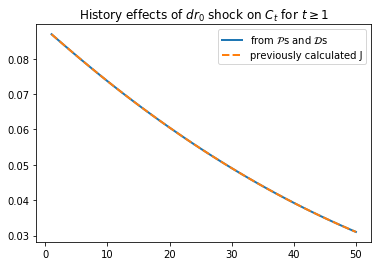

In [23]:
# need to calculate curlyP_t'curlyD_0 for t from 0 to 50
# curlyP has dimension T*S*A, curlyD[0] has dimension S*A
# calculate by flattening S*A into single state-space dimension for both, then matrix multiplying
history_C_from_r0 = curlyP['C'][:50, ...].reshape((50, -1)) @ curlyD['r'][0, ...].ravel()

# now do comparison plot to what we already know it is
plt.plot(np.arange(1,51), history_C_from_r0, label=r'from $\mathcal{P}$s and $\mathcal{D}$s', linewidth=2)
plt.plot(np.arange(1,51), J_from_curlyYD['C']['r'][1:51, 0], linestyle='--', label='previously calculated J', linewidth=2)
plt.legend()
plt.title(r'History effects of $dr_0$ shock on $C_t$ for $t\geq 1$')
plt.show()

Perfect success!

Alternatively, if there is a shock $dr$ at date 1, then this leads to different behavior at dates 0 and 1, resulting in changes to the distribution going forward. The history effect on consumption at date 2 is $\mathcal{P}_1'\mathcal{D}_1 + \mathcal{P}_0'\mathcal{D}_0$, on consumption at date 3 is $\mathcal{P}_2'\mathcal{D}_1 + \mathcal{P}_1'\mathcal{D}_0$, and so on. Let's calculate these and compare to the relevant Jacobian entries. Note that we can economize somewhat on computation, because in the previous application we already found the second term in each of these: $\mathcal{P}_0'\mathcal{D}_0, \mathcal{P}_1'\mathcal{D}_0, \ldots$.

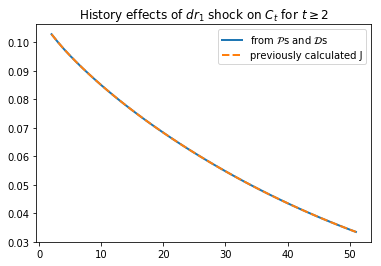

In [24]:
# need to calculate curlyP_(t+1)'curlyD_1 + curlyP_t'curlyD_0 for t from 0 to 50
# already calculated latter term above, now just calculate former using same method
history_C_from_r1 = curlyP['C'][1:51, ...].reshape((50, -1)) @ curlyD['r'][1, ...].ravel()
history_C_from_r1 += history_C_from_r0

# now do comparison plot to what we already know it is
plt.plot(np.arange(2,52), history_C_from_r1, label=r'from $\mathcal{P}$s and $\mathcal{D}$s', linewidth=2)
plt.plot(np.arange(2,52), J_from_curlyYD['C']['r'][2:52, 1], linestyle='--', label='previously calculated J', linewidth=2)
plt.legend()
plt.title(r'History effects of $dr_1$ shock on $C_t$ for $t\geq 2$')
plt.show()

Again, we have perfect success.

How would we go about generalizing these computations, in order to calculate all the entries in Jacobians? First, since we're only calculating history effects here, we would need to add current effects. Since we found an easy way to calculate current effects in section 2.1, though, this is not difficult.

Second, we need to calculate history effects for shocks that occur later. The formulas for these history effects become progressively more complicated, because they add more and more terms. For instance, a shock that occurs at time 10 implies a history effect at time $t\geq 11$ of

\begin{align*}
\mathcal{P}_{t-1}'\mathcal{D}_{10} + \mathcal{P}_{t-2}'\mathcal{D}_{9} + \ldots + \mathcal{P}_{t-10}'\mathcal{D}_1 + \mathcal{P}_{t-11}'\mathcal{D}_0
\end{align*}

To avoid expensively calculating these ever-more-complicated sums (which for a shock that occurs at time 100 would have 101 terms!), we need some tricks. We used one trick in our last calculation: we realized that we'd already calculated $\mathcal{P}_t\mathcal{D}_0$ terms for the $s=0$ shock, and that we could reuse them for the $s=1$ shock. In the next section, we will show that a generalization of this trick provides a route to rapid computation of the Jacobian.

## 4 The fake news matrix and assembling the Jacobian
Let's restate our formulas from the beginning of section 3, now writing explicitly as derivatives with respect to a shock at date $s$, and using the definition of $\mathcal{P}$:

\begin{align}
\frac{dY_0}{dZ_s} &= \mathcal{Y}_s \\
\frac{dY_1}{dZ_s} &= \mathcal{Y}_{s-1} + \mathcal{P}_0'\mathcal{D}_{s-1} \\
\frac{dY_2}{dZ_s} &= \mathcal{Y}_{s-2} + \mathcal{P}_0'\mathcal{D}_{s-2} + \mathcal{P}_1'\mathcal{D}_{s-1} \\
\frac{dY_3}{dZ_s} &= \mathcal{Y}_{s-3} + \mathcal{P}_0'\mathcal{D}_{s-3} + \mathcal{P}_1'\mathcal{D}_{s-2} + \mathcal{P}_2'\mathcal{D}_{s-1}\\
\cdots &= \cdots
\end{align}

From inspection, we can see that the following recursion holds for , along with an initial condition at $t=0$:

\begin{align*}
\frac{dY_t}{dZ_s} = 
\begin{cases}
\mathbf{1}_{s\geq 1}\frac{dY_{t-1}}{dZ_{s-1}} + \mathcal{P}_{t-1}'\mathcal{D}_s & t \geq 1 \\
\frac{dY_0}{dZ_s} = \mathcal{Y}_s & t=0 \tag{6}
\end{cases}
\end{align*}

For instance, $\frac{dY_2}{dZ_{s+1}} = \mathcal{Y}_{s-1} + \mathcal{P}_0'\mathcal{D}_{s-1} + \mathcal{P}_1'\mathcal{D}_{s} = \frac{dY_1}{dZ_s} + \mathcal{P}_1'\mathcal{D}_{s}$.

The intuition behind (6) for $t\geq 1$ is the following. Due to time symmetry, the aggregate outcome at date 60 from a shock at date 50 is exactly the same as the aggregate outcome at date 59 from a shock at date 49, with one exception: there is an extra period of anticipation (50 periods in advance) for the date-50 shock, and the anticipatory response persists through the distribution at date 60.

Following (6), this effect is captured by $\mathcal{P}_{59}'\mathcal{D}_{50}$: $\mathcal{D}_{50}$ gives the effect on the distribution at date 1 from anticipating the shock 50 periods in advance (and then changing policy) at date 0, and $\mathcal{P}_{59}'$ finds the effect of this distributional perturbation on the aggregate outcome 59 periods hence at date 60.

The $t=0$ case is just a restatement of the $\frac{dY_0}{dZ_s}$ we already derived, and is trivial: at date 0, the beginning-of-period distribution is by necessity unchanged, and hence there is only the current effect $\mathcal{Y}_s$ and no history effect.

### 4.1 "Fake news matrix" interpretation
To better interpret (6), define a matrix $F$ with entries:

$
F_{t,s} \equiv 
\begin{cases}
\mathcal{P}_{t-1}'\mathcal{D}_s & t \geq 1 \\
\mathcal{Y}_s & t = 0 \tag{7}
\end{cases}
$

Each entry $F_{t,s}$ of this matrix has the following interpretation. At date 0, agents learn that there will be a shock at date $s$. If $s=0$, this shock actually happens. Otherwise, at date 1, agents find out that there will not be a shock at date $s$ after all: the news shock at date 0 was *fake news*. In either case, $F_{t,s}$ traces out the effect on the aggregate outcome of interest for all $t$.

Combining (6) and (7), we see that the actual Jacobian can be built up recursively from $F_{t,s}$ as

$
J_{t,s} \equiv \frac{dY_t}{dZ_s} = 
\begin{cases}
\mathbf{1}_{s\geq 1} J_{t-1,s-1} + F_{t,s} & t\geq 1\\
F_{t,s} & t=0\tag{8}
\end{cases}
$

In short, as we step along a diagonal of the Jacobian matrix $J$ from $J_{t-1,s-1}$ to $J_{t,s}$, we add the corresponding entry $F_{t,s}$ of the fake news matrix.

The intuition is just a restatement of our intuition for (6), now in terms of the fake news matrix. Time symmetry means that the aggregate outcome at date $t$ from a shock at date $s$ is the same as the aggregate outcome at date $t-1$ from a shock at date $s-1$, except that with the former we have an extra period of anticipation. The effect at time $t$ from that extra period of anticipation is, to first order, exactly the same as the effect at time $t$ of a date-$s$ fake news shock.

We now have an easy recipe to calculate the Jacobian $J_{t,s}$ from the underlying $\mathcal{Y}$s, $\mathcal{D}$s, and $\mathcal{P}$s: first generate the fake news matrix (7), then apply (8) to convert it to the true Jacobian.

### 4.2 Implementation
We start by implementing (7) with a very simple function, which is included in `het_block.py`. This takes in only the $\mathcal{Y}$s, $\mathcal{D}$s, and $\mathcal{P}$s (in the format in which we've constructed them).

In [25]:
def build_F(curlyYs, curlyDs, curlyPs):
    """Take in dim-T curlyYs, dim-T*n curlyDs, and dim-T*n curlyPs to build fake news matrix,
    where size-n state space may be spread across multiple dimensions"""
    T = curlyDs.shape[0]
    F = np.empty((T, T))
    F[0, :] = curlyYs
    F[1:, :] = curlyPs[:T - 1, ...].reshape((T - 1, -1)) @ curlyDs.reshape((T, -1)).T
    return F

Let's apply this for the consumption response to wage changes, and plot the columns of the fake news matrix for a few early $s$:

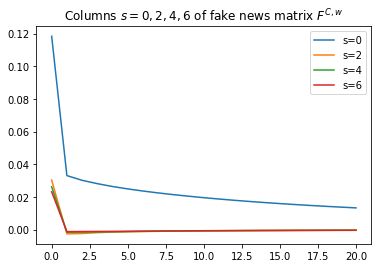

In [26]:
F = build_F(curlyY['C']['w'], curlyD['w'], curlyP['C'])
for s in (0, 2, 4, 6):
    plt.plot(F[:21, s], label=f's={s}')
plt.legend()
plt.title(r'Columns $s=0,2,4,6$ of fake news matrix $F^{C,w}$')
plt.show()

By far the biggest and most distinctive is the $s=0$ column, which is the only column of the fake news matrix that does *not* correspond to fake news: the shock actually happens at $s=0$. Unsurprisingly, this increase in wages leads to an immediate rise in consumption, followed by sustained higher consumption in later periods.

The $s=2,4,6$ columns, on the other hand, are the impulses to fake news: at date 0 households "learn" that there will be a wage shock at $s=2,4,6$, but then at date 1 they find out this was false. Here, we see an anticipatory rise in consumption at date 0, larger for $s$ closer to 0, followed by sustained (slightly) lower consumption as agents rebuild their depleted asset positions.

Next, we implement the recursion (8) with an even simpler function, also included in `het_block.py`.

In [27]:
def J_from_F(F):
    J = F.copy()
    for t in range(1, J.shape[0]):
        J[1:, t] += J[:-1, t - 1]
    return J

Let's apply `build_F` and then `J_from_F` to make Jacobians for *all* outcomes and inputs.

In [28]:
%%time
F = {o: {} for o in outcomes}

# loop over outcomes and inputs to apply build_F
for o in outcomes:
    for i in inputs:
        F[o][i] = build_F(curlyY[o][i], curlyD[i], curlyP[o])

CPU times: user 168 ms, sys: 5.04 ms, total: 173 ms
Wall time: 88.6 ms


In [29]:
%%time
J = {o: {} for o in outcomes}

# loop over outcomes and inputs to apply build_F
for o in outcomes:
    for i in inputs:
        J[o][i] = J_from_F(F[o][i])

CPU times: user 10.1 ms, sys: 3.74 ms, total: 13.9 ms
Wall time: 11.2 ms


Together, these computations are remarkably fast: only a fraction of a second!

Most of the time is taken by the `build_F`, which is unsurprising when we realize that it is involves operations on the grid (multiplication of $\mathcal{P}$s and $\mathcal{D}$s, both of which have dimension equal to the size of the state space), while `J_from_F` is just an operation on individual Jacobian matrices. `build_F` still manages to be fairly efficient, however, because it is implemented using matrix multiplication, which is usually highly optimized at the machine level.

Let's quickly verify that we get almost exactly the same answers as our earlier Jacobian calculation, down to the 14th decimal place.

In [30]:
for o in outcomes:
    diffs = [np.max(np.abs(J[o][i] - J_from_curlyYD[o][i])) for i in inputs]
    print(f'Outcome {o} max diff for inputs: ')
    print(',\t'.join([f'{i}: {d:.3e}' for i, d in zip(inputs, diffs)]) + '\n')

Outcome A max diff for inputs: 
w: 1.638e-14,	r: 2.854e-14

Outcome C max diff for inputs: 
w: 4.186e-15,	r: 4.569e-15

Outcome N max diff for inputs: 
w: 7.452e-15,	r: 6.547e-15

Outcome NS max diff for inputs: 
w: 3.497e-15,	r: 6.037e-15



## 5 General code
We now have a recipe for efficiently computing the Jacobian: use one backward iteration for each input to calculate the $\mathcal{Y}^{o,i}$s and $\mathcal{D}^i$s as in section 2, use one transpose forward iteration for each outcome to calculate the $\mathcal{P}^o$s as in section 3, and then finally build the fake news matrix $F^{o,i}$ and from it the Jacobian $J^{o,i}$ for each outcome-input pair, as in section 4.

In this section, we'll discuss the **general implementation** of this recipe, in the `het_block.py` module, that goes into the `het_block.all_Js` function.

One preliminary: there is a function `het_block.extract_info` that does some useful pre-processing, examining the source code to determine the inputs and outcomes in the backward step function, in addition to the name of the variable used in backward iteration. Although this function is fairly short, it is technical and Python-specific enough that we will defer it to `het_block.py`.

### 5.1 Getting $\mathcal{Y}$s and $\mathcal{D}$s
This is the most complicated part of the code. First, we write a `backward_step` function that takes in shocked inputs along with a variety of steady-state information, and does a single linearized backward step using the numerical differentiator in `utils.numerical_diff`. This gives the linearized impact on the backward variable (which we call `curlyV`), along with the idiosyncratic change `da` in the policy for the endogenous variable, which we convert to our Markov matrix representation and apply to the steady-state distribution to get `curlyD`, as well as the idiosyncratic changes `dy` in each outcome, which we aggregate using the steady-state distribution to get the dict `curlyY`.

In [31]:
def backward_step(dinput_dict, back_step_fun, ssinput_dict, ssy_list, outcome_list, D, Pi, a_pol_i, a_grid_space, h=1E-4):
    # shock perturbs policies
    curlyV, da, *dy_list = utils.numerical_diff(back_step_fun, ssinput_dict, dinput_dict, h, ssy_list)

    # which affects the distribution tomorrow
    da_pol_pi = -da / a_grid_space
    curlyD = utils.forward_step_policy_shock(D, Pi.T, a_pol_i, da_pol_pi)

    # and the aggregate outcomes today
    curlyY = {name: np.vdot(D, dy) for name, dy in zip(outcome_list, [da] + dy_list)}

    return curlyV, curlyD, curlyY

The `backward_iteration` function then starts with an input shock and repeatedly applies this `backward_step` function, getting `curlyYs` and `curlyDs` with time indices.

It is important to distinguish between two different applications of `backward_step`. The first gives us the contemporaneous response to the shock itself. From this we get $\mathcal{Y}_0$ and $\mathcal{D}_0$. All later applications give only *anticipatory* responses that are transmitted through changes in the backward iteration variable (generally either the value function or marginal value function), labeled "curlyV" here.

In [32]:
def backward_iteration(shock, back_step_fun, ssinput_dict, ssy_list, outcome_list, V_name, D, Pi, a_pol_i, a_grid_space, T):
    """Iterate policy steps backward T times for a single shock."""
    # contemporaneous response to unit scalar shock
    curlyV, curlyD, curlyY = backward_step(shock, back_step_fun, ssinput_dict,
                                           ssy_list, outcome_list, D, Pi, a_pol_i, a_grid_space)

    # infer dimensions from this and initialize empty arrays
    curlyDs = np.empty((T,) + curlyD.shape)
    curlyYs = {k: np.empty(T) for k in curlyY.keys()}

    # fill in current effect of shock
    curlyDs[0, ...] = curlyD
    for k in curlyY.keys():
        curlyYs[k][0] = curlyY[k]

    # fill in anticipation effects
    for t in range(1, T):
        curlyV, curlyDs[t, ...], curlyY = backward_step({V_name + '_p': curlyV}, back_step_fun, ssinput_dict,
                                                        ssy_list, outcome_list, D, Pi, a_pol_i, a_grid_space)
        for k in curlyY.keys():
            curlyYs[k][t] = curlyY[k]

    return curlyYs, curlyDs

It is worth noting that both `backward_shock` and `backward_iteration` operate only on a single shock to inputs. Of course, this shock can affect multiple inputs to the iteration simultaneously (which is why it is specified as a dict). But assembling Jacobians in response to multiple shocks will only come later, in section 5.4, where we will do multiple applications of `backward_iteration` as necessary.

### 5.2 Getting $\mathcal{P}$s, aka "prediction vectors"
This function is an analog to `backward_iteration` above, but by contrast it is extremely simple.

In [33]:
def forward_iteration_transpose(y_ss, Pi, a_pol_i, a_pol_pi, T):
    """Iterate transpose forward T steps to get full set of prediction vectors for a given outcome."""
    curlyPs = np.empty((T,) + y_ss.shape)
    curlyPs[0, ...] = y_ss
    for t in range(1, T):
        curlyPs[t, ...] = utils.forward_step_transpose(curlyPs[t-1, ...], Pi, a_pol_i, a_pol_pi)
    return curlyPs

It just applies our steady-state Markov matrix, which we encode using `Pi`, `a_pol_i`, and `a_pol_pi`, repeatedly to an input `y_ss`, to generate all the prediction vectors $\mathcal{P}_0=y_{ss}, \mathcal{P}_1=\Lambda_{ss}y_{ss}, \mathcal{P}_2=(\Lambda_{ss})'y_{ss},\ldots$ 

The application of $\Lambda_{ss}$ is done using the function `utils.forward_step_transpose`, so named because it is literally the transpose operation of applying $\Lambda_{ss}'$, which is ordinarily the way we update the distribution and do forward iteration.

### 5.3 Construct fake news matrix and Jacobian
This part just involves the functions `build_F` and `J_from_F`, which we already defined in section 4.2.

### 5.4 Putting it all together
Finally, we write a single `all_Js` function that computes all Jacobians with respect to a certain set of income shocks. It has only 4 inputs: the backward step function itself `back_step_fun` (which, under our conventions, encodes everything we need to know about the heterogeneous-agent model), the steady-state dictionary `ss`, the horizon over which we want to compute the Jacobian `T`, and a nested dict `shock_dict` giving the input shocks with respect to which we want to compute the Jacobian.

**Understanding `shock_dict`.** The last input is perhaps the most unintuitive, so it bears a moment of explanation. If we want to find the Jacobians with respect to `r` and `w`, we would write `shock_dict = {'r': {'r':1}, 'w': {'w':1}}`. Why the seeming redundancy? We want to allow for the possibility that there is not a one-to-one mapping between the aggregate inputs to the household sector (with respect to which we want to find Jacobians) and the explicit inputs of `back_step_fun`. A good example of this is in the `demo_hank` notebook, where we calculate the Jacobian of the heterogeneous household block by writing:
```Python
T_div = ss['div_rule'] / np.sum(ss['pi_s'] * ss['div_rule'])
T_tax = -ss['tax_rule'] / np.sum(ss['pi_s'] * ss['tax_rule'])
J_ha = het.all_Js(backward_iterate_labor, ss, T, {'r': {'r': 1},
                                                  'w': {'w': 1},
                                                  'Div': {'T': T_div},
                                                  'Tax': {'T': T_tax}})
```
`T_div` and `T_tax` are both vectors that give the incidence of aggregate dividends and taxes on individuals in different states. To find the Jacobian with respect to a change in aggregate dividends `Div`, we put an entry into `shock_dict` that maps `Div` to a perturbation `T_div` to the lump-sum transfer input `T` into the household problem. Such generality is important to be able to flexibly accommodate different macro embeddings of the same heterogeneous-agent model.

**Code for `all_Js`**. With that detour out of the way, it's time to look at the code for the `all_Js` function, which combines all the steps we've discussed so far: steps 1-3 directly rely upon sections 5.1-5.3.

In [34]:
from het_block import extract_info
def all_Js(back_step_fun, ss, T, shock_dict):
    # preliminary a: process back_step_funtion
    ssinput_dict, ssy_list, outcome_list, V_name = extract_info(back_step_fun, ss)

    # preliminary b: get sparse representation of asset policy rule, then distances between neighboring policy gridpoints
    a_pol_i, a_pol_pi = utils.interpolate_coord(ss['a_grid'], ss['a'])
    a_grid_space = ss['a_grid'][a_pol_i + 1] - ss['a_grid'][a_pol_i]

    # step 1: compute curlyY and curlyD (backward iteration) for each input i
    curlyYs, curlyDs = dict(), dict()
    for i, shock in shock_dict.items():
        curlyYs[i], curlyDs[i] = backward_iteration(shock, back_step_fun, ssinput_dict, ssy_list, outcome_list,
                                                    V_name, ss['D'], ss['Pi'], a_pol_i, a_grid_space, T)

    # step 2: compute prediction vectors curlyP (forward iteration) for each outcome o
    curlyPs = dict()
    for o, ssy in zip(outcome_list, ssy_list[1:]):
        curlyPs[o] = forward_iteration_transpose(ssy, ss['Pi'], a_pol_i, a_pol_pi, T)

    # step 3: make fake news matrix and Jacobian for each outcome-input pair
    J = {o: {} for o in outcome_list}
    for o in outcome_list:
        for i in shock_dict:
            F = build_F(curlyYs[i][o], curlyDs[i], curlyPs[o])
            J[o][i] = J_from_F(F)

    # remap outcomes to capital letters to avoid conflicts
    for k in list(J.keys()):
        K = k.upper()
        J[K] = J.pop(k)

    # report Jacobians
    return J

The preliminary code applies `extract_info` to get information from the structure of the backward iteration function, and then calculates the sparse steady-state Markov matrix (along with `a_grid_space`, which is needed for the backward iteartion).

Step 1 simply applies `backward_iteration` for each input shock in `shock_dict` and stores the results from each in an input-specific dict. (One caveat: the resulting `curlyYs` nested dict nests inputs and outputs in the opposite order from what we've used in this notebook and in the notation, `curlyYs[i][o]` rather than `curlyYs[o][i]`. This is for brevity.)

Step 2 similarly applies `forward_iteration_transpose` for each outcome. Then step 3 builds the fake news matrix and Jacobian for each outcome-input pair.

Finally, a small piece of housekeeping at the end makes sure that outcomes are listed in the output Jacobian dict `J` with capital rather than lowercase letters. This is to make the Jacobian conform to our usual convention (as in the steady-state dict `ss`) that capital letters refer to aggregate outcomes and lowercase letters refer to individual outcomes in the het-agent sector.

### 5.5 Running the code
Let's finally run this `all_Js` method to get the same Jacobians as before.

In [37]:
%time J_code = all_Js(hank.backward_iterate_labor, ss, T, {'r': {'r': 1}, 'w': {'w': 1}})

CPU times: user 426 ms, sys: 15.4 ms, total: 442 ms
Wall time: 369 ms


We see that this delivers 8 (four outcomes and two inputs) $T\times T = 300\times 300$ Jacobians in around half a second -- quite fast, about 400 times faster than the brute-force approach per input! With these Jacobians in hand, we can almost immediately calculate the first-order response of the household sector to any shocks to the path of $r$ or $w$.

To make sure that this fully automated code for the Jacobian is correct, let's compare to the Jacobians we manually built from $\mathcal{Y}$s, $\mathcal{D}$s, and $\mathcal{P}$s in section 4.

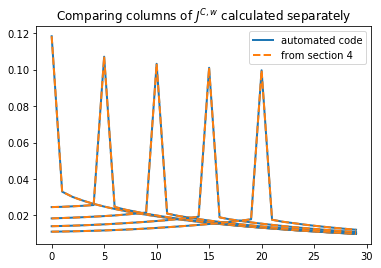

In [38]:
columns = (0, 5, 10, 15, 20)
l1, l2 = 'automated code', 'from section 4'
for col in columns:
    plt.plot(J_code['C']['w'][:30, col], label=l1, linewidth=2, color='C0')
    plt.plot(J['C']['w'][:30, col], label=l2, linestyle='--', linewidth=2, color='C1')
    l1, l2 = '_nolegend_', '_nolegend_' # suppress extra legends
plt.title('Comparing columns of $J^{C,w}$ calculated separately')
plt.legend()
plt.show()

Or we can repeat our direct comparison of the Jacobians, showing the max absolute difference between all entries of each:

In [39]:
for o in outcomes:
    diffs = [np.max(np.abs(J_code[o][i] - J[o][i])) for i in inputs]
    print(f'Outcome {o} max diff for inputs: ')
    print(',\t'.join([f'{i}: {d:.3e}' for i, d in zip(inputs, diffs)]) + '\n')

Outcome A max diff for inputs: 
w: 3.146e-04,	r: 3.146e-04

Outcome C max diff for inputs: 
w: 3.688e-06,	r: 3.688e-06

Outcome N max diff for inputs: 
w: 2.929e-06,	r: 2.929e-06

Outcome NS max diff for inputs: 
w: 3.792e-06,	r: 3.792e-06



Note that some small differences appear because of nonlinearities, since `backward_iteration` inside `all_Js` uses a different approach (repeatedly numerically differentiating, rather than doing a single nonlinear pass before dividing by $h$) than what we used earlier to get the $\mathcal{Y}$s and $\mathcal{D}$s. The answer given by `all_Js` is closer to the true linearization.